In [5]:
import yaml
import os
import torch
import torchvision
import sys

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import imageio
from skimage import img_as_ubyte

sys.path.append("../../")
from model.vae import VAE_Model
import numpy as np
import matplotlib.pyplot as plt
from edflow.hooks.checkpoint_hooks.common import get_latest_checkpoint
#os.environ["CUDA_VISIBLE_DEVICES"] = "9"    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_config(run_path):
    run_config_path = run_path + "/configs/"
    run_config_path = run_config_path + os.listdir(run_config_path)[-1]
    with open(run_config_path) as fh:
        config = yaml.full_load(fh)
    return config

def load_pca(run_path):
    pca_path = run_path + "/pca/"
    if not os.path.isdir(pca_path):
        print("ERROR: pca_path does not exist. Check your run_path or if you already executed the callback operation.")
    eig_vec = np.load(pca_path + "eig_vec.npy")
    eig_val = np.load(pca_path + "eig_val.npy")
    return eig_val, eig_vec

In [ ]:
# here you have to enter the path to the run which should be vied
#run_path = "VAE/logs/2020-02-26T20-26-12_up_vae_some_sky_0"
#run_path = "/export/home/rhaecker/documents/Machine-Learning-on-individual-data/log_ex/2020-02-21T14-32-46_vae_3_conv_3-1-factor0.02"
run_path = "VAE/logs/2020-03-30T12-25-27_test/eval/2020-03-30T12-25-27_test/900/model_outputs"
working_directory = '/export/home/rhaecker/documents/research-of-latent-representation/'
if run_path[-1]==["/"]:
    run_path = run_path[:-1]
run_path = working_directory + run_path

config = load_config(run_path)
eig_val, eig_vec = load_pca(run_path)

In [4]:
# load Model with latest checkpoint
vae = VAE_Model(config)
checkpoint_path = run_path + "/train/checkpoints/"
latest_chkpt_path = get_latest_checkpoint(checkpoint_root = checkpoint_path)
vae.load_state_dict(torch.load(latest_chkpt_path)["model"])
vae = vae.to(device)
#print(vae.tensor_shapes)

INFO:VAE_Model:[[3, 64, 64], [32, 32, 32], [32, 16, 16], [64, 8, 8], [4096], [32]]


Padding of the convolutions is set to 1


In [5]:
def plot_eig_val():
    idx_lambda = np.arange(0,len(eig_val),1)
    plt.figure(figsize=(15,7))
    plt.bar(idx_lambda, eig_val)
    plt.ylabel("eigenvalue $\lambda$")
    plt.xlabel("index of eigenvector")
    plt.show()

# Functions to look at the latent representation
def view_one_pc(mu = 0, delta=20, pc_num=0, num_images=5):
    final = get_one_pc(mu, delta, pc_num, num_images)
    plt.figure(figsize=(20,20))
    plt.xlabel("factor of principle component " + str(pc_num))
    lab_pos = np.arange(32,64*num_images,64)
    x_lab = np.linspace(mu-delta,mu+delta,num_images)
    plt.xticks(lab_pos, np.round(x_lab,1))
    plt.imshow(final)
    plt.show()
    
def get_one_pc(mu = 0, delta=20, pc_num=0, num_images=5):
    x = torch.linspace(mu-delta,mu+delta,num_images).to(device)
    pc = torch.from_numpy(eig_vec[pc_num]).to(device).double()

    z = torch.zeros([num_images,config["linear"]["latent_dim"]], dtype=torch.float).to(device)
    for i in range(num_images):
        z[i] = pc * x[i]
    img = vae.latent_sample(z)
    img = img.detach().cpu().permute([0,2,3,1]).numpy()
    img = (img + 1)/2
    final = np.hstack(img)
    return final

def view_pc(mu=0, delta=20, num_pc=1, num_images=5, save=False):
    pc = np.arange(0,num_pc,1)
    final = []
    for i in range(num_pc):
        final.append(get_one_pc(mu, delta, pc[i], num_images))
    
    final = np.asarray(final)
    final = np.vstack(final)
    plt.figure(figsize=(num_images*1.5,num_pc*1.5))
    
    plt.xlabel("factor of principle components")
    plt.ylabel("principle component")
    lab_pos_x = np.arange(32,64*num_images,64)
    x_lab = np.linspace(mu-delta,mu+delta,num_images)
    lab_pos_y = np.arange(32,64*num_pc,64)
    plt.xticks(lab_pos_x, np.round(x_lab,1))
    plt.yticks(lab_pos_y, pc)
    plt.imshow(final)
    if save:
        plt.savefig("figures/view_pc_num_pc" + str(pc_num) + "_num_images" + str(num_images) + "_mu" + str(mu) + "delta" + str(delta) + ".jpg" )
    plt.show()
    
def view_two_added_pc(mu_1 = 0, delta_1 = 20, mu_2 = 0, delta_2 = 20, pc_num_start=0, num_images_x=5, num_images_y=5, save=False):
    x1 = torch.linspace(mu_1-delta_1,mu_1+delta_1,num_images_x)
    x2 = torch.linspace(mu_2-delta_2,mu_2+delta_2,num_images_y)
    
    pc1 = torch.from_numpy(eig_vec[pc_num_start]).to(device)
    pc2 = torch.from_numpy(eig_vec[pc_num_start+1]).to(device)
    
    z = torch.zeros([num_images_x,config["linear"]["latent_dim"]], dtype=torch.float).to(device)
    h_final = []
    for j in range(num_images_y):
        for i in range(num_images_x):
            z[i] = pc1 * x1[i] + pc2 * x2[j]
        img = vae.latent_sample(z)
        img = img.detach().cpu().permute([0,2,3,1]).numpy()
        img = (img + 1)/2
        h_final.append(np.hstack(img))
    h_final = np.asarray(h_final)
    final = np.vstack(h_final)
    plt.figure(figsize=(num_images_x*1.5,num_images_y*1.5))
    
    name_start = run_path.rfind("/")
    plt.title("Two added PC's from: " + run_path[name_start+20:])
    plt.imshow(final)
    plt.xlabel("factor of principle component " + str(pc_num_start))
    plt.ylabel("factor of principle component " + str(pc_num_start+1))
    lab_x_pos = np.arange(32,64*num_images_x,64)
    lab_y_pos = np.arange(32,64*num_images_y,64)
    x_lab = x1.detach().cpu().numpy()
    y_lab = x2.detach().cpu().numpy()
    plt.xticks(lab_x_pos, np.round(x_lab,1))
    plt.yticks(lab_y_pos, np.round(y_lab,1))
    if save:
        plt.savefig("figures/pc_2dim_mu_1_" + str(mu_1) + "__mu_2_" + str(mu_2) + ".jpg" )
    plt.show()

In [6]:
cont_up = True
interact(view_one_pc, mu =widgets.FloatSlider(min=-100,max=100,step=0.5, value=0, continuous_update=cont_up), 
                     delta=widgets.FloatSlider(min=-100,max=100,step=1, value=10, continuous_update=cont_up),
                     pc_num=widgets.IntSlider(min=0, max=30, step=1, value=0),
                     num_images=widgets.IntSlider(min=0, max=20, step=1, value=5))

interact(view_pc, mu = widgets.FloatSlider(min=-100,max=100,step=0.5, value=0, continuous_update=cont_up), 
               delta = widgets.FloatSlider(min=0,max=150,step=1, value=10, continuous_update=cont_up),
              num_pc = widgets.IntSlider(min=1, max=30, step=1, value=0),
          num_images = widgets.IntSlider(min=1, max=20, step=1, value=5))

interact(view_two_added_pc,mu_1 = widgets.FloatSlider(min=-50,max=50,step=0.5, value=0, continuous_update=cont_up),
                        delta_1 = widgets.FloatSlider(min=0,max=50,step=0.5, value=10,continuous_update=cont_up), 
                           mu_2 = widgets.FloatSlider(min=-50,max=50,step=0.5, value=0, continuous_update=cont_up), 
                        delta_2 = widgets.FloatSlider(min=0,max=50,step=0.5, value=10,continuous_update=cont_up), 
                   pc_num_start = widgets.IntSlider(min=0, max=30, step=1, value=0),
                   num_images_x = widgets.IntSlider(min=1, max=30, step=1, value=5),
                   num_images_y = widgets.IntSlider(min=1, max=30, step=1, value=5))

interactive(children=(FloatSlider(value=0.0, description='mu', min=-100.0, step=0.5), FloatSlider(value=10.0, …

interactive(children=(FloatSlider(value=0.0, description='mu', min=-100.0, step=0.5), FloatSlider(value=10.0, …

interactive(children=(FloatSlider(value=0.0, description='mu_1', max=50.0, min=-50.0, step=0.5), FloatSlider(v…

<function __main__.view_two_added_pc(mu_1=0, delta_1=20, mu_2=0, delta_2=20, pc_num_start=0, num_images_x=5, num_images_y=5, save=False)>

In [25]:
# functions to create gifs
def save_image_seq(mu = 0, delta=50, pc_num=0, numb_images=250, loop_gif=False):
    pca_path = run_path + "/pca/"
    gif_path = pca_path + "results/gifs"
    if not os.path.isdir(gif_path):
            os.makedirs(gif_path)
    if type(pc_num) in [list,np.ndarray]:
        gifs = []
        for i in range(len(pc_num)):
            all_images = create_image_seq(mu, delta, pc_num[i], numb_images, loop_gif)
            gifs.append(all_images)
        gifs = np.asarray(gifs)
        gifs = np.concatenate((gifs[:]),axis=2)
        imageio.mimsave(gif_path + "/pc_numbers" + str(pc_num[0]) + "-" + str(pc_num[-1]) + "_mu" + str(mu) + "_delta" + str(delta) + '.gif', gifs)
    else:
        all_images = create_image_seq(mu, delta, pc_num, numb_images)
        imageio.mimsave(gif_path + "/pc_numb" + str(pc_num) + "_mu" + str(mu) + "_delta" + str(delta) + '.gif', all_images)

def create_image_seq(mu = 0, delta=50, pc_num=0, numb_images=250, loop_gif=False):
    xx = torch.linspace(mu-delta,mu+delta,numb_images).to(device)
    pc = torch.from_numpy(eig_vec[pc_num]).to(device).double()
    
    all_images = []
    z = torch.zeros([numb_images,config["linear"]["latent_dim"]], dtype=torch.float).to(device)
    for i in range(numb_images):
        z[i] = pc * xx[i]
    img = vae.latent_sample(z)
    img = img.detach().cpu().permute([0,2,3,1]).numpy()
    img = (img + 1)/2
    img = img_as_ubyte(img)
    for i in range(numb_images):
        all_images.append(img[i])
    if loop_gif:
        for i in range(numb_images):
            z[i] = pc * xx[-i-1]
        img = vae.latent_sample(z)
        img = img.detach().cpu().permute([0,2,3,1]).numpy()
        img = (img + 1)/2
        img = img_as_ubyte(img)
        for i in range(numb_images):
            all_images.append(img[i])
    return all_images

In [26]:
# save many gifs
num = np.arange(0,8,1)
save_image_seq(pc_num=num, numb_images=50,loop_gif = True)

# UMAP

In [102]:
# get raw data points
raw_data_path = run_path + "/eval/"
raw_data_path = raw_data_path + os.listdir(raw_data_path)[-1] + "/"
logs_list = list(map(int, os.listdir(raw_data_path)))
logs_list = np.sort(logs_list)
raw_data_path = raw_data_path + str(logs_list[-1]) + "/model_outputs/labels/"
raw_data_path = raw_data_path + os.listdir(raw_data_path)[-1] 
print(raw_data_path)

meta_path = os.path.join(os.path.dirname(raw_data_path), '..')

/export/home/rhaecker/documents/research-of-latent-representation/VAE/logs/2020-02-26T20-26-12_up_vae_some_sky_0/eval/2020-02-26T20-26-12_up_vae_some_sky_0/360000/model_outputs/labels/latent_rep-*-1000x32-*-float32.npy


In [98]:
from edflow.data.believers.meta import MetaDataset

In [103]:
Jdata = MetaDataset(meta_path)

In [104]:
Jdata.show()

# Model Outputs


# Labels
|         Name |     Type |      Content |
|--------------|----------|--------------|
|   latent_rep |   memmap |   (1000, 32) |


# Example 0
|                 Name |     Type |   Content |
|----------------------|----------|-----------|
|               index_ |      int |         0 |
|   labels_/latent_rep |   memmap |     (32,) |


In [105]:
reps = Jdata.labels['latent_rep']
print(reps.shape)

(1000, 32)


In [76]:
f = "latent_rep-*-1000x32-*-float32.npy"
key, shape, dtype = f.split("-*-")
shape = tuple([int(s) for s in shape.split("x")])

data = np.memmap(raw_data_path, mode="c", shape=shape, dtype=np.float32).copy()

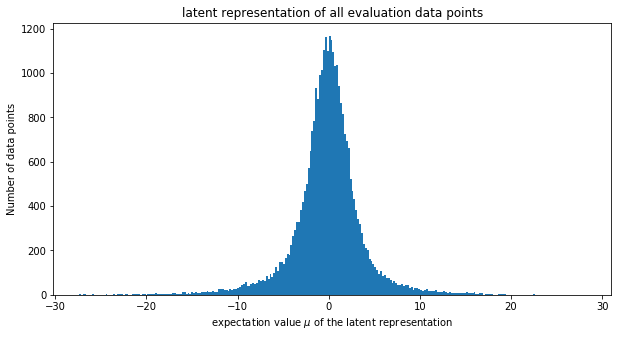

In [86]:
plt.figure(figsize=(10,5))
plt.hist(data.flatten(), bins="auto")
plt.xlabel("expectation value $\mu$ of the latent representation")
plt.ylabel("Number of data points")
plt.title("latent representation of all evaluation data points")
plt.show()

In [87]:
import umap

In [88]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)
embedding.shape

(1000, 2)

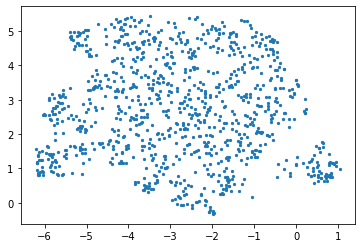

In [93]:
plt.scatter(embedding[:,0], embedding[:,1],s=5)
plt.show()

In [97]:
config["data_root"]

'/export/home/rhaecker/documents/Machine-Learning-on-individual-data/data/vae_var_some_sky'